# 10. Milestone Project 3: Time series forecasting in TensorFlow (BitPredict 💰📈)

The goal of this notebook is to get you familiar with working with time series data.

We're going to be building a series of models in an attempt to predict the price of Bitcoin. 

Welcome to Milestone Project 3, BitPredict 💰📈!

> 🔑 **Note:** ⚠️ This is not financial advice, as you'll see time series forecasting for stock market prices is actually quite terrible.

## What is a time series problem?

Time series problems deal with data over time.

Such as, the number of staff members in a company over 10-years, sales of computers for the past 5-years, electricity usage for the past 50-years.

The timeline can be short (seconds/minutes) or long (years/decades). And the problems you might investigate using can usually be broken down into two categories.

![example time series problems](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-example-time-series-problems.png)

| Problem Type | Examples | Output |
| ----- | ----- | ----- |
| **Classification** | Anomaly detection, time series identification (where did this time series come from?) | Discrete (a label) |
| **Forecasting** | Predicting stock market prices, forecasting future demand for a product, stocking inventory requirements | Continuous (a number) |

In both cases above, a supervised learning approach is often used. Meaning, you'd have some example data and a label assosciated with that data.

For example, in forecasting the price of Bitcoin, your data could be the historical price of Bitcoin for the past month and the label could be today's price (the label can't be tomorrow's price because that's what we'd want to predict).

Can you guess what kind of problem BitPredict 💰📈 is?

## What we're going to cover

Are you ready?

We've got a lot to go through. 

* Get time series data (the historical price of Bitcoin)
  * Load in time series data using pandas/Python's CSV module
* Format data for a time series problem
  * Creating training and test sets (the wrong way)
  * Creating training and test sets (the right way)
  * Visualizing time series data
  * Turning time series data into a supervised learning problem (windowing)
  * Preparing univariate and multivariate (more than one variable) data
* Evaluating a time series forecasting model
* Setting up a series of deep learning modelling experiments
  * Dense (fully-connected) networks
  * Sequence models (LSTM and 1D CNN)
  * Ensembling (combining multiple models together)
  * Multivariate models
  * Replicating the N-BEATS algorithm using TensorFlow layer subclassing
* Creating a modelling checkpoint to save the best performing model during training
* Making predictions (forecasts) with a time series model
* Creating prediction intervals for time series model forecasts
* Discussing two different types of uncertainty in machine learning (data uncertainty and model uncertainty)
* Demonstrating why forecasting in an open system is BS (the turkey problem) 

## How you can use this notebook
You can read through the descriptions and the code (it should all run), but there's a better option.

Write all of the code yourself.

Yes. I'm serious. Create a new notebook, and rewrite each line by yourself. Investigate it, see if you can break it, why does it break?

You don't have to write the text descriptions but writing the code yourself is a great way to get hands-on experience.

Don't worry if you make mistakes, we all do. The way to get better and make less mistakes is to **write more code**.

> 📖 **Resource:** Get all of the materials you need for this notebook on the [course GitHub](https://github.com/mrdbourke/tensorflow-deep-learning).

## Get data

To build a time series forecasting model, the first thing we're going to need is data.

And since we're trying to predict the price of Bitcoin, we'll need Bitcoin data.

Specifically, we're going to get the prices of Bitcoin from 01 October 2013 to 18 May 2021.

Why these dates?

Because 01 October 2013 is when our data source ([Coindesk](https://www.coindesk.com/price/bitcoin)) started recording the price of Bitcoin and 18 May 2021 is when this notebook was created.

If you're going through this notebook at a later date, you'll be able to use what you learn to predict on later dates of Bitcoin, you'll just have to adjust the data source.

> 📖 **Resource:** To get the Bitcoin historical data, I went to the [Coindesk page for Bitcoin prices](https://www.coindesk.com/price/bitcoin), clicked on "all" and then clicked on "Export data" and selected "CSV". 

You can find the data we're going to use on [GitHub](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv).




In [1]:
# Download Bitcoin historical data from GitHub 
# Note: you'll need to select "Raw" to download the data in the correct format
#!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

In [2]:
import pandas as pd
import numpy as np

In [3]:
# parse dates and set date column to index
df = pd.read_csv('bitcoin.csv',
                parse_dates=['Date'],
                index_col=['Date']) # parse the date column (tell pandas column 1 is datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [5]:
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but there's only 2787 total samples.

This is something you'll run into with time series data problems. Often, the number of samples isn't as large as other kinds of data.

For example, collecting one sample at different time frames results in:

| 1 sample per timeframe | Number of samples per year |
| ----- | ----- |
| Second | 31,536,000 |
| Hour | 8,760 |
| Day | 365 |
| Week | 52 |
| Month | 12 |

> 🔑 **Note:** The frequency at which a time series value is collected is often referred to as **seasonality**. This is usually mesaured in number of samples per year. For example, collecting the price of Bitcoin once per day would result in a time series with a seasonality of 365. Time series data collected with different seasonality values often exhibit seasonal patterns (e.g. electricity demand behing higher in Summer months for air conditioning than Winter months). For more on different time series patterns, see [Forecasting: Principles and Practice Chapter 2.3](https://otexts.com/fpp3/tspatterns.html).

![different types of time series patterns](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-types-of-time-series-patterns.png)
*Example of different kinds of patterns you'll see in time series data. Notice the bottom right time series (Google stock price changes) has little to no patterns, making it difficult to predict. See [Forecasting: Principles and Practice Chapter 2.3](https://otexts.com/fpp3/tspatterns.html) for full graphic.*

Deep learning algorithms usually flourish with lots of data, in the range of thousands to millions of samples.

In our case, we've got the daily prices of Bitcoin, a max of 365 samples per year.

But that doesn't we can't try them with our data.

To simplify, let's remove some of the columns from our data so we're only left with a date index and the closing price.

In [6]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={'Closing Price (USD)':'Price'})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


Much better!

But that's only five days worth of Bitcoin prices, let's plot everything we've got.

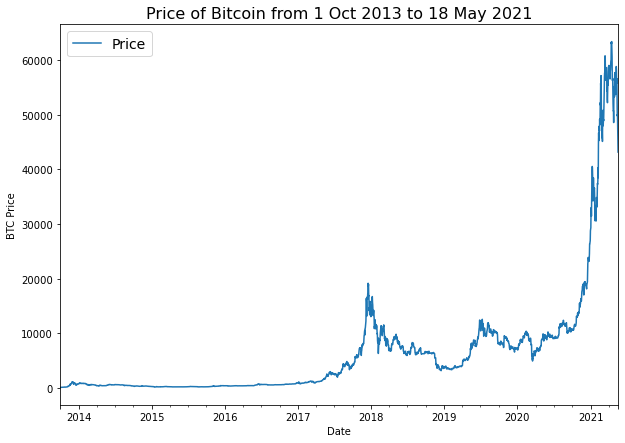

In [7]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel('BTC Price')
plt.title('Price of Bitcoin from 1 Oct 2013 to 18 May 2021',fontsize=16)
plt.legend(fontsize=14)

### Importing time series data with Python's CSV module

If your time series data comes in CSV form you don't necessarily have to use pandas.

You can use Python's [in-built `csv` module](https://docs.python.org/3/library/csv.html). And if you're working with dates, you might also want to use Python's [`datetime`](https://docs.python.org/3/library/datetime.html).

Let's see how we can replicate the plot we created before except this time using Python's `csv` and `datetime` modules.

> 📖 **Resource:** For a great guide on using Python's `csv` module, check out Real Python's tutorial on [Reading and Writing CSV files in Python](https://realpython.com/python-csv/).

In [8]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open('bitcoin.csv','r') as f:
    csv_reader = csv.reader(f,delimiter=',') # read in the target csv
    next(csv_reader) # skip first line (this gets rid of the column titles)
    for line in csv_reader:
        # get the dates as dates (not strings), strptime = string parse time
        timesteps.append(datetime.strptime(line[1],'%Y-%m-%d'))
        # get the closing price as float
        btc_price.append(float(line[2]))

# view first 10 of each
for t,p in zip(timesteps[:10],btc_price[:10]):
    print(t,p)

2013-10-01 00:00:00 123.65499
2013-10-02 00:00:00 125.455
2013-10-03 00:00:00 108.58483
2013-10-04 00:00:00 118.67466
2013-10-05 00:00:00 121.33866
2013-10-06 00:00:00 120.65533
2013-10-07 00:00:00 121.795
2013-10-08 00:00:00 123.033
2013-10-09 00:00:00 124.049
2013-10-10 00:00:00 125.96116


Text(0, 0.5, 'BTC Price')

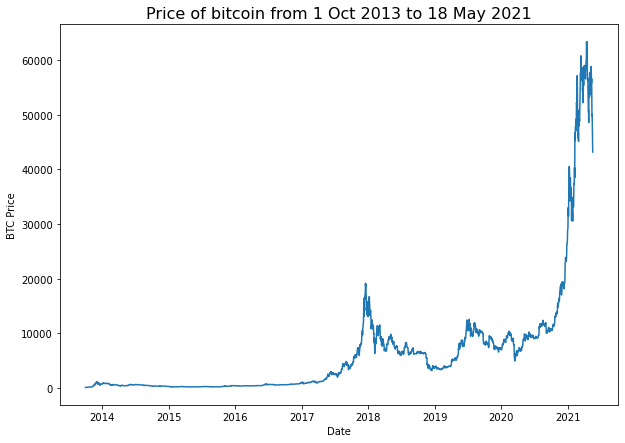

In [9]:
plt.figure(figsize=(10,7))
plt.plot(timesteps,btc_price)
plt.title('Price of bitcoin from 1 Oct 2013 to 18 May 2021',fontsize=16)
plt.xlabel('Date')
plt.ylabel('BTC Price')

## Format Data Part 1: Creatining train and test sets for time series data

Alrighty. What's next?

If you guessed preparing our data for a model, you'd be right.

What's the most important first step for preparing any machine learning dataset?

Scaling?

No...

Removing outliers?

No...

How about creating train and test splits?

Yes! 

Usually, you could create a train and test split using a function like Scikit-Learn's outstanding [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) but as we'll see in a moment, this doesn't really cut it for time series data.

But before we do create splits, it's worth talking about what *kind* of data we have.

In time series problems, you'll either have **univariate** or **multivariate** data.

Can you guess what our data is?

* **Univariate** time series data deals with *one* variable, for example, using the price of Bitcoin to predict the price of Bitcoin.
* **Multivariate** time series data deals with *more than one* variable, for example, predicting electricity demand using the day of week, time of year and number of houses in a region.

![comparison of univariate and multivariate time series data](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-univariate-and-multivariate-time-series-data.png)
*Example of univariate and multivariate time series data. Univariate involves using the target to predict the target. Multivariate inolves using the target as well as another time series to predict the target.*

### Create train & test sets for time series (the wrong way)

Okay, we've figured out we're dealing with a univariate time series, so we only have to make a split on one variable (for multivariate time series, you will have to split multiple variables). 

How about we first see the *wrong way* for splitting time series data?

Let's turn our DataFrame index and column into NumPy arrays.

In [10]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()
timesteps[:10],prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

And now we'll use the ever faithful `train_test_split` from Scikit-Learn to create our train and test sets.

In [13]:
# Wrong way to make train/test set for time series
from sklearn.model_selection import train_test_split

In [14]:
X_train,X_test,y_train,y_test= train_test_split(timesteps,prices,test_size= 0.2,random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2229,)
(558,)
(2229,)
(558,)


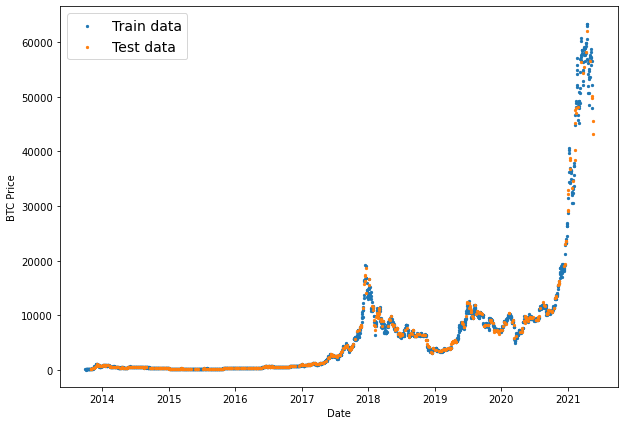

In [16]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10,7))
plt.scatter(X_train,y_train,s=5,label='Train data')
plt.scatter(X_test,y_test,s=5,label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=14)
plt.show()

### Create train & test sets for time series (the right way)

Of course, there's no way we can actually access data from the future.

But we can engineer our test set to be in the future with respect to the training set.

To do this, we can create an abitrary point in time to split our data.

Everything before the point in time can be considered the training set and everything after the point in time can be considered the test set.

![time series train test split](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-time-series-train-test-split.png)
*Demonstration of time series split. Rather than a traditionaly random train/test split, it's best to split the time series data sequentially. Meaning, the test data should be data from the future when compared to the training data.*

In [17]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits
X_train,y_train = timesteps[:split_size],prices[:split_size]

# Create test splits
X_test,y_test = timesteps[split_size:],prices[split_size:]

len(X_train),len(X_test),len(y_train),len(y_test)

(2229, 558, 2229, 558)

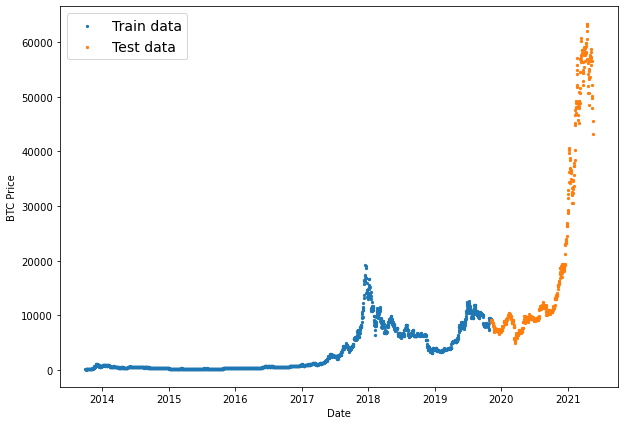

In [18]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10,7))
plt.scatter(X_train,y_train,s=5,label='Train data')
plt.scatter(X_test,y_test,s=5,label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=14)
plt.show()

In [19]:
# Create a function to plot time series data
def plot_time_series(timesteps,values,format='.',start=0,end=None,label=None):
    '''
    Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
    Parameters
    ---------
    timesteps : array of timesteps
    values : array of values across time
    format : style of plot, default "."
    start : where to start the plot (setting a value will index from start of timesteps & values)
    end : where to end the plot (setting a value will index from end of timesteps & values)
    label : label to show on plot of values
    '''
    # Plot the series
    plt.plot(timesteps[start:end],values[start:end],format,label=label)
    plt.xlabel('Time')
    plt.ylabel('BTC price')
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.grid(True)

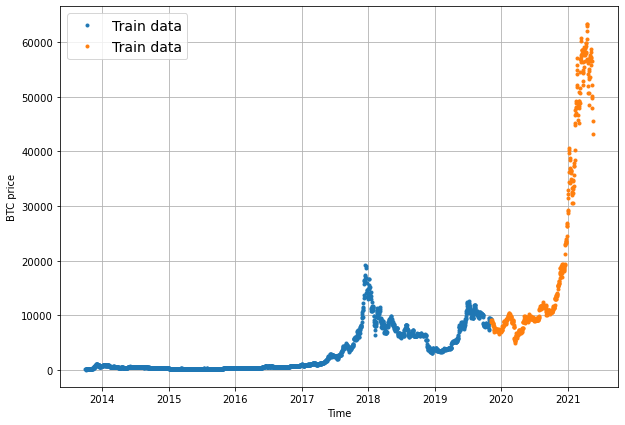

In [20]:
# Try out our plotting function
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train,values=y_train,label='Train data')
plot_time_series(timesteps=X_test,values=y_test,label='Train data')

## Modelling Experiments

We can build almost any kind of model for our problem as long as the data inputs and outputs are formatted correctly.

However, just because we *can* build *almost any* kind of model, doesn't mean it'll perform well/should be used in a production setting.

We'll see what this means as we build and evaluate models throughout.

Before we discuss what modelling experiments we're going to run, there are two terms you should be familiar with, **horizon** and **window**. 
  * **horizon** = number of timesteps to predict into future
  * **window** = number of timesteps from past used to predict **horizon**

For example, if we wanted to predict the price of Bitcoin for tomorrow (1 day in the future) using the previous week's worth of Bitcoin prices (7 days in the past), the horizon would be 1 and the window would be 7.

Now, how about those modelling experiments?

| Model Number | Model Type | Horizon size | Window size | Extra data |
| ----- | ----- | ----- | ----- | ----- |
| 0 | Naïve model (baseline) | NA | NA | NA |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA | 
| 3 | Same as 1 | 7 | 30 | NA |
| 4 | Conv1D | 1 | 7 | NA |
| 5 | LSTM | 1 | 7 | NA |
| 6 | Same as 1 (but with multivariate data) | 1 | 7 | Block reward size |
| 7 | [N-BEATs Algorithm](https://arxiv.org/pdf/1905.10437.pdf) | 1 | 7 | NA |
| 8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA | 
| 9 | Future prediction model (model to predict future values) | 1 | 7 | NA| 
| 10 | Same as 1 (but with turkey 🦃 data introduced) | 1 | 7 | NA |

> 🔑 **Note:** To reiterate, as you can see, we can build many types of models for the data we're working with. But that doesn't mean that they'll perform well. Deep learning is a powerful technique but it doesn't always work. And as always, start with a simple model first and then add complexity as needed. 

## Model 0: Naïve forecast (baseline)

As usual, let's start with a baseline.

One of the most common baseline models for time series forecasting, the naïve model (also called the [naïve forecast](https://otexts.com/fpp3/simple-methods.html#na%C3%AFve-method)), requires no training at all.

That's because all the naïve model does is use the previous timestep value to predict the next timestep value.

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$ 

In English: 
> The prediction at timestep `t` (y-hat) is equal to the value at timestep `t-1` (the previous timestep).

Sound simple?

Maybe not.

In an open system (like a stock market or crypto market), you'll often find beating the naïve forecast with *any* kind of model is quite hard.

> 🔑 **Note:** For the sake of this notebook, an **open system** is a system where inputs and outputs can freely flow, such as a market (stock or crypto). Where as, a **closed system** the inputs and outputs are contained within the system (like a poker game with your buddies, you know the buy in and you know how much the winner can get). Time series forecasting in **open systems** is generally quite poor.

In [21]:
# Create a naive forecast
naive_forecast = y_test[:-1] # Naive forecast equals every value excluding the last value
naive_forecast[:10],naive_forecast[-10:] # View first 10 and last 10

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

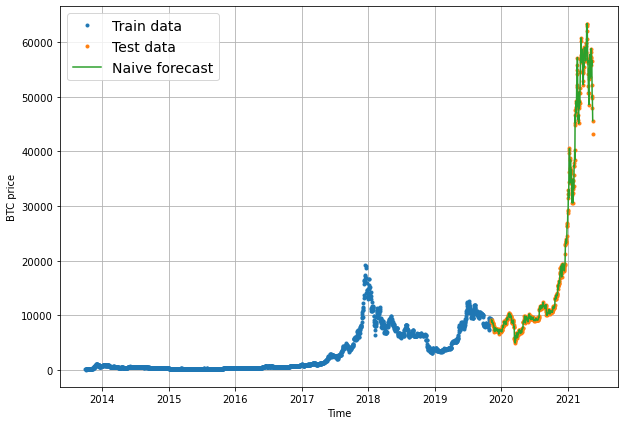

In [22]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

The naive forecast looks like it's following the data well. 

Let's zoom in to take a better look.

We can do so by creating an offset value and passing it to the `start` parameter of our `plot_time_series()` function.

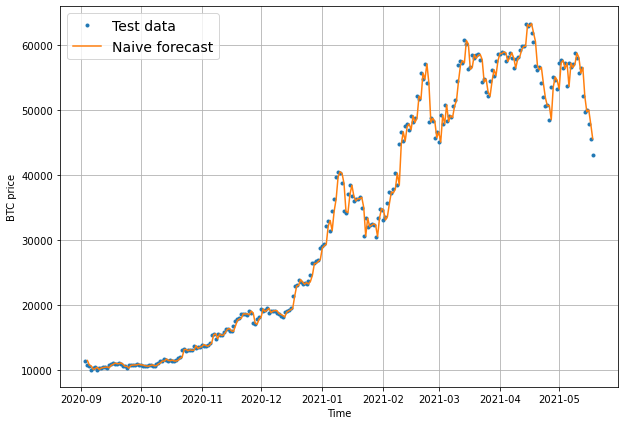

In [23]:
plt.figure(figsize=(10,7))
offsets = 300 # offset the values by 300 timesteps
plot_time_series(timesteps=X_test,values=y_test,start=offsets,label='Test data')
plot_time_series(timesteps=X_test[1:],values=naive_forecast,format='-',start=offsets,label='Naive forecast')

## Evaluating a time series model

Time series forecasting often involves predicting a number (in our case, the price of Bitcoin).

And what kind of problem is predicting a number?

Ten points if you said regression.

With this known, we can use regression evaluation metrics to evaluate our time series forecasts.

The main thing we will be evaluating is: **how do our model's predictions (`y_pred`) compare against the actual values (`y_true` or *ground truth values*)**? 

> 📖 **Resource:** We're going to be using several metrics to evaluate our different model's time series forecast accuracy. Many of them are sourced and explained mathematically and conceptually in [Forecasting: Principles and Practice chapter 5.8](https://otexts.com/fpp3/accuracy.html), I'd recommend reading through here for a more in-depth overview of what we're going to practice.

For all of the following metrics, **lower is better** (for example an MAE of 0 is better than an MAE 100).

### Scale-dependent errors

These are metrics which can be used to compare time series values and forecasts that are on the same scale.

For example, Bitcoin historical prices in USD veresus Bitcoin forecast values in USD.

| Metric | Details | Code |
| ----- | ----- | ----- |
| **MAE** (mean absolute error) | Easy to interpret (a forecast is X amount different from actual amount). Forecast methods which minimises the MAE will lead to forecasts of the median. | [`tf.keras.metrics.mean_absolute_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanAbsoluteError) |
| **RMSE** (root mean square error) | Forecasts which minimise the RMSE lead to forecasts of the mean. | `tf.sqrt(`[`tf.keras.metrics.mean_square_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/RootMeanSquaredError)`)`|

### Percentage errors

Percentage errors do not have units, this means they can be used to compare forecasts across different datasets.

| **Metric** | **Details** | **Code** |
| ----- | ----- | ----- |
| **MAPE** (mean absolute percentage error) | Most commonly used percentage error. May explode (not work) if `y=0`. | [`tf.keras.metrics.mean_absolute_percentage_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MAPE) | 
| **sMAPE** (symmetric mean absolute percentage error) | Recommended not to be used by [Forecasting: Principles and Practice](https://otexts.com/fpp3/accuracy.html#percentage-errors), though it is used in forecasting competitions. | Custom implementation |

### Scaled errors

Scaled errors are an alternative to percentage errors when comparing forecast performance across different time series.

| **Metric** | **Details** | **Code** |
| ----- | ----- | ----- |
| **MASE** (mean absolute scaled error). | MASE equals one for the naive forecast (or very close to one). A forecast which performs better than the naïve should get <1 MASE. | See sktime's [`mase_loss()`](https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16) |

> 🤔 **Question:** There are so many metrics... which one should I pay most attention to? It's going to depend on your problem. However, since its ease of interpretation (you can explain it in a sentence to your grandma), MAE is often a very good place to start.

Since we're going to be evaluing a lot of models, let's write a function to help us calculate evaluation metrics on their forecasts.

First we'll need TensorFlow.


In [25]:
# let import tensorflow
import tensorflow as tf
print(tf.__version__)

2.6.0


In [35]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true,y_pred):
    '''
    Implement MASE (assuming no seasonality of data)
    '''
    mae = tf.reduce_mean(tf.abs(y_true-y_pred))
    # find MAE of navie forecast (no seasonality)
    # our seasonality is 1 day (hence the shifting of 1 day)
    mea_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))
    return mae / mea_naive_no_season

You'll notice the version of MASE above doesn't take in the training values like sktime's `mae_loss()`. In our case, we're comparing the MAE of our predictions on the test to the MAE of the naïve forecast on the test set.

In practice, if we've created the function correctly, the naïve model should achieve an MASE of 1 (or very close to 1). Any model worse than the naïve forecast will achieve an MASE of >1 and any model better than the naïve forecast will achieve an MASE of <1.

Let's put each of our different evaluation metrics together into a function.

In [38]:
def evaluate_preds(y_true,y_pred):
    # Make sure float32 (for metric calculations)
    y_true = tf.cast(y_true,dtype=tf.float32)
    y_pred = tf.cast(y_pred,dtype=tf.float32)
    # calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true,y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true,y_pred) # puts and emplasis on outliers (all errors get squared)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
    mase = mean_absolute_scaled_error(y_true,y_pred)
    
    metric = {'mae':mae.numpy(),
             'mse':mse.numpy(),
             'rmse':rmse.numpy(),
             'mape':mape.numpy(),
             'mase':mase.numpy()}
    
    return metric

In [39]:
# test function on the naive forecast
naive_results=  evaluate_preds(y_true=y_test[1:],
                              y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.9995699}

Alright, looks like we've got some baselines to beat.

Taking a look at the naïve forecast's MAE, it seems on average each forecast is ~$567 different than the actual Bitcoin price.

How does this compare to the average price of Bitcoin in the test dataset?

In [40]:
# Find average price of bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

20056.632963737226

## Other kinds of time series forecasting models which can be used for baselines and actual forecasts

Since we've got a naïve forecast baseline to work with, it's time we start building models to try and beat it.

And because this course is focused on TensorFlow and deep learning, we're going to be using TensorFlow to build deep learning models to try and improve on our naïve forecasting results.

That being said, there are many other kinds of models you may want to look into for building baselines/performing forecasts.

Some of them may even beat our best performing models in this notebook, however, I'll leave trying them out for extra-curriculum.

| **Model/Library Name** | **Resource** |
| ----- | ----- |
| Moving average | https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/ |
| ARIMA (Autoregression Integrated Moving Average) | https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ |
| sktime (Scikit-Learn for time series) | https://github.com/alan-turing-institute/sktime |
| TensorFlow Decision Forests (random forest, gradient boosting trees) | https://www.tensorflow.org/decision_forests |
| Facebook Kats (purpose-built forecasting and time series analysis library by Facebook) | https://github.com/facebookresearch/Kats | 
| LinkedIn Greykite (flexible, intuitive and fast forecasts) | https://github.com/linkedin/greykite |

## Format Data Part 2: Windowing dataset

Surely we'd be ready to start building models by now?

We're so close! Only one more step (really two) to go.

We've got to window our time series.

Why do we window?

Windowing is a method to turn a time series dataset into **supervised learning problem**. 

In other words, we want to use windows of the past to predict the future.

For example for a univariate time series, windowing for one week (`window=7`) to predict the next single value (`horizon=1`) might look like:

```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

Or for the price of Bitcoin, it'd look like:

```
Window for one week with the target of predicting the next day (Bitcoin prices)

[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]
```

![windows and horizons for turning time series data into a supervised learning problem](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-time-series-windows-and-horizons.png)
*Example of windows and horizons for Bitcoin data. Windowing can be used to turn time series data into a supervised learning problem.*

Let's build some functions which take in a univariate time series and turn it into windows and horizons of specified sizes.

We'll start with the default horizon size of 1 and a window size of 7 (these aren't necessarily the best values to use, I've just picked them).

In [74]:
HORIZON = 1 # predict 1 step at time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [75]:
# Create function to label windowed data
def get_labelled_windows(x,horizon=1):
    '''
    Creates labels for windowed dataset.
    E.g if horizon=1 (default)
    Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
    '''
    return(x[:,:-horizon],x[:,-horizon:])

In [76]:
data = tf.expand_dims(tf.range(8),axis=0)
data[:,-1:]

<tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[7]])>

In [77]:
# Test out the window labeling function
data = tf.expand_dims(tf.range(8)+1,axis=0)
test_window, test_label = get_labelled_windows(data,horizon=HORIZON)
print(f'Window: {tf.squeeze(test_window).numpy()}->Label: {tf.squeeze(test_label).numpy()}')

Window: [1 2 3 4 5 6 7]->Label: 8


Oh yeah, that's what I'm talking about!

Now we need a way to make windows for an entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite slow.

To speed things up, we'll leverage [NumPy's array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html).

Let's write a function which:
1. Creates a window step of specific window size, for example: `[[0, 1, 2, 3, 4, 5, 6, 7]]`
2. Uses NumPy indexing to create a 2D of multiple window steps, for example: 
```
[[0, 1, 2, 3, 4, 5, 6, 7],
 [1, 2, 3, 4, 5, 6, 7, 8],
 [2, 3, 4, 5, 6, 7, 8, 9]]
```
3. Uses the 2D array of multuple window steps to index on a target series
4. Uses the `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon

> 📖 **Resource:** The function created below has been adapted from Syafiq Kamarul Azman's article [*Fast and Robust Sliding Window Vectorization with NumPy*](https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5).

In [78]:
# Create function to view Numpy arrays as windows
def make_windows(x,window_size=7,horizon=1):
    '''
    Turn a 1D array into a 2D array of sequential windows of window size
    '''
    # 1.Create a windwo of specific window_size (add the horizon on th end for later labelling)
    window_step = np.expand_dims(np.arange(window_size+horizon),axis=0)
    # print(f"Window step:\n {window_step}")
    # 2.Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)),axis=0).T# create 2D array of windows of size window_size
    # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")
    # 3.Index on the target array (time series) with 2D array of multiple window steps
    windowed_array = x[window_indexes]
    # 4.Get the labelled windows
    windows,labels = get_labelled_windows(windowed_array,horizon=horizon)
    return windows,labels

In [94]:
# wiew the first 3 windows|labels
full_windows,full_labels = make_windows(prices,window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_windows),len(full_labels)

(2780, 2780)

In [95]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


> 🔑 **Note:** You can find a function which achieves similar results to the ones we implemented above at [`tf.keras.preprocessing.timeseries_dataset_from_array()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array). Just like ours, it takes in an array and returns a windowed dataset. It has the benefit of returning data in the form of a tf.data.Dataset instance (we'll see how to do this with our own data later).

## Turning windows into training and test sets 

Look how good those windows look! Almost like the stain glass windows on the Sistine Chapel, well, maybe not that good but still.

Time to turn our windows into training and test splits.

We could've windowed our existing training and test splits, however, with the nature of windowing (windowing often requires an offset at some point in the data), it usually works better to window the data first, then split it into training and test sets.

Let's write a function which takes in full sets of windows and their labels and splits them into train and test splits.

In [96]:
# Make the train/test splits
def make_train_test_splits(windows,labels,test_split=0.2):
    '''
    Split mathcing pairs windwos and albesl into train and test splits
    '''
    split_size = int(len(windows) * (1-test_split)) # number of sample correspond to 80% train and 20%
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows,test_windows,train_labels,test_labels

In [102]:
train_windows,test_windows,train_labels,test_labels = make_train_test_splits(full_windows,full_labels)
len(train_windows),len(test_windows),len(train_labels),len(test_labels)
print(train_windows.shape)
print(test_windows.shape)
print(train_labels.shape)
print(test_labels.shape)

(2224, 7)
(556, 7)
(2224, 1)
(556, 1)


Notice the default split of 80% training data and 20% testing data (this split can be adjusted if needed).

How do the first 5 samples of the training windows and labels looks?

In [103]:
train_windows[:5]

array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  ],
       [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
        123.033  ],
       [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
        124.049  ],
       [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
        125.96116],
       [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
        125.27966]])

In [104]:
train_labels[:5]

array([[123.033  ],
       [124.049  ],
       [125.96116],
       [125.27966],
       [125.9275 ]])

In [105]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]),y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint

We're so close to building models. So so so close.

Because our model's performance will fluctuate from experiment to experiment, we'll want to make sure we're comparing apples to apples.

What I mean by this is in order for a fair comparison, we want to compare each model's best performance against each model's best performance.

For example, if `model_1` performed incredibly well on epoch 55 but its performance fell off toward epoch 100, we want the version of the model from epoch 55 to compare to other models rather than the version of the model from epoch 100.

And the same goes for each of our other models: compare the best against the best.

To take of this, we'll implement a [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback.

The `ModelCheckpoint` callback will monitor our model's performance during training and save the best model to file by setting `save_best_only=True`.

That way when evaluating our model we could restore its best performing configuration from file.

> 🔑 **Note:** Because of the size of the dataset (smaller than usual), you'll notice our modelling experiment results fluctuate quite a bit during training (hence the implementation of the `ModelCheckpoint` callback to save the best model).

Because we're going to be running multiple experiments, it makes sense to keep track of them by saving models to file under different names.

To do this, we'll write a small function to create a `ModelCheckpoint` callback which saves a model to specified filename.

In [107]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name,save_path='model_exp'):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path,model_name), # create filepath to save model
                                              verbose=0, # only output a limited amount of text
                                              save_best_only=True # save only the best model file
                                             )

## Model 1: Dense model (window = 7, horizon = 1)

Finally!

Time to build one of our models.

If you think we've been through a fair bit of preprocessing before getting here, you're right.

Often, preparing data for a model is one of the largest parts of any machine learning project.

And once you've got a good model in place, you'll probably notice far more improvements from manipulating the data (e.g. collecting more, improving the quality) than manipulating the model.

We're going to start by keeping it simple, `model_1` will have:
* A single dense layer with 128 hidden units and ReLU (rectified linear unit) activation
* An output layer with linear activation (or no activation)
* Adam optimizer and MAE loss function
* Batch size of 128
* 100 epochs

Why these values?

I picked them out of experimentation. 

A batch size of 32 works pretty well too and we could always train for less epochs but since the model runs so fast (you'll see in a second, it's because the number of samples we have isn't massive) we might as well train for more.

> 🔑 **Note:** As always, many of the values for machine learning problems are experimental. A reminder that the values you can set yourself in a machine learning algorithm (the hidden units, the batch size, horizon size, window size) are called [**hyperparameters**](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning). And experimenting to find the best values for hyperparameters is called **hyperparameter tuning**. Where as parameters learned by a model itself (patterns in the data, formally called weights & biases) are referred to as **parameters**.

Let's import TensorFlow and build our first deep learning model for time series.

In [111]:
import tensorflow as tf
from tensorflow.keras import layers

# set random for as reproducible results as possible
tf.random.set_seed(42)

# construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128,activation='relu'),
    layers.Dense(HORIZON,activation='linear') # linear activation is the same as having no activation
],name = 'model_1_dense') # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# fit model
history_1 = model_1.fit(x=train_windows,
           y=train_labels,
           epochs=100,
           verbose=1,
           batch_size=128,
           validation_data=(test_windows,test_labels),
           callbacks=[create_model_checkpoint(model_name=model_1.name)])# create ModelCheckpoint callback to save best model

Epoch 1/100
18/18 [==============================] - 1s 10ms/step - loss: 780.3469 - mae: 780.3469 - val_loss: 2279.5830 - val_mae: 2279.5830
INFO:tensorflow:Assets written to: model_exp\model_1_dense\assets
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 247.6765 - mae: 247.6765 - val_loss: 1005.9865 - val_mae: 1005.9865
INFO:tensorflow:Assets written to: model_exp\model_1_dense\assets
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 188.4107 - mae: 188.4107 - val_loss: 923.2859 - val_mae: 923.2859
INFO:tensorflow:Assets written to: model_exp\model_1_dense\assets
Epoch 4/100
18/18 [==============================] - 0s 3ms/step - loss: 169.4334 - mae: 169.4334 - val_loss: 900.5931 - val_mae: 900.5931
INFO:tensorflow:Assets written to: model_exp\model_1_dense\assets
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 165.0899 - mae: 165.0899 - val_loss: 895.2402 - val_mae: 895.2402
INFO:tensorflow:Assets written to: m

18/18 [==============================] - 0s 3ms/step - loss: 108.9936 - mae: 108.9936 - val_loss: 636.0566 - val_mae: 636.0566
Epoch 48/100
18/18 [==============================] - 0s 4ms/step - loss: 109.2967 - mae: 109.2967 - val_loss: 604.1573 - val_mae: 604.1573
Epoch 49/100
18/18 [==============================] - 0s 4ms/step - loss: 111.7787 - mae: 111.7787 - val_loss: 591.5085 - val_mae: 591.5085
Epoch 50/100
18/18 [==============================] - 0s 4ms/step - loss: 111.7319 - mae: 111.7319 - val_loss: 636.4696 - val_mae: 636.4696
Epoch 51/100
18/18 [==============================] - 0s 3ms/step - loss: 110.7498 - mae: 110.7498 - val_loss: 589.2868 - val_mae: 589.2868
Epoch 52/100
18/18 [==============================] - 0s 3ms/step - loss: 111.5192 - mae: 111.5192 - val_loss: 609.5305 - val_mae: 609.5305
Epoch 53/100
18/18 [==============================] - 0s 3ms/step - loss: 113.9869 - mae: 113.9869 - val_loss: 584.7464 - val_mae: 584.7464
INFO:tensorflow:Assets written to

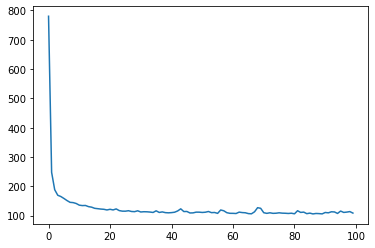

In [121]:
import matplotlib.pyplot as plt

plt.plot(np.array(history_1.history['loss']))

Because of the small size of our data (less than 3000 total samples), the model trains very fast.

Let's evaluate it.

In [122]:
# evaluate model on test data
model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 633.1995 - mae: 633.1995


[633.1995239257812, 633.1995239257812]

You'll notice the model achieves the same `val_loss` (in this case, this is MAE) as the last epoch.

But if we load in the version of `model_1` which was saved to file using the `ModelCheckpoint` callback, we should see an improvement in results.

In [124]:
# load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model('model_exp/model_1_dense')
model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 568.6370 - mae: 568.6370


[568.6370239257812, 568.6370239257812]

Much better! Due to the fluctuating performance of the model during training, loading back in the best performing model see's a sizeable improvement in MAE.

## Making forecasts with a model (on the test dataset)

We've trained a model and evaluated the it on the test data, but the project we're working on is called BitPredict 💰📈 so how do you think we could use our model to make predictions?

Since we're going to be running more modelling experiments, let's write a function which: 
1. Takes in a trained model (just like `model_1`)
2. Takes in some input data (just like the data the model was trained on) 
3. Passes the input data to the model's `predict()` method
4. Returns the predictions



In [125]:
def make_preds(model,input_data):
    '''
    Uses model to make predictions on input_data
    Params
    ---
    model: trained_model
    input_data: windowed input data (same kind of data model was trained on)
    Returns
    ---
    model predictions on input_data
    '''
    forecast = model.predict(input_data)
    return tf.squeeze(forecast) # return 1D array predictions

In [127]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1,test_windows)
len(model_1_preds),model_1_preds[:10]

(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8875.922, 8783.567, 9031.465, 8814.604, 8740.123, 8744.625,
        8707.005, 8517.839, 8474.502, 8530.751], dtype=float32)>)

> 🔑 **Note:** With these outputs, our model isn't *forecasting* yet. It's only making predictions on the test dataset. Forecasting would involve a model making predictions into the future, however, the test dataset is only a pseudofuture.

Excellent! Now we've got some prediction values, let's use the `evaluate_preds()` we created before to compare them to the ground truth.

In [128]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                y_pred=model_1_preds)
model_1_results

{'mae': 568.637,
 'mse': 1174330.2,
 'rmse': 1083.6652,
 'mape': 2.5478518,
 'mase': 0.9989377}

In [129]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.9995699}

It looks like our naïve model beats our first deep model on nearly every metric.

That goes to show the power of the naïve model and the reason for having a baseline for any machine learning project.

And of course, no evaluation would be finished without visualizing the results.

Let's use the `plot_time_series()` function to plot `model_1_preds` against the test data.

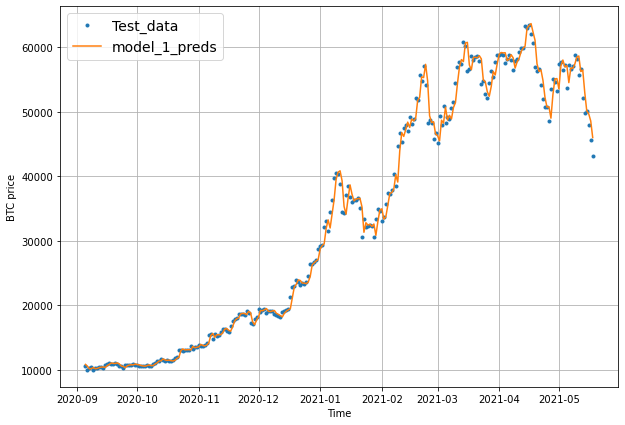

In [130]:
offset = 300
plt.figure(figsize=(10,7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:,0],start=offset,label='Test_data')
plot_time_series(timesteps=X_test[-len(test_windows):],values=model_1_preds,start=offset,format='-',label='model_1_preds')

What's wrong with these predictions?

As mentioned before, they're on the test dataset. So they're not actual forecasts.

With our current model setup, how do you think we'd make forecasts for the future?

Have a think about it for now, we'll cover this later on.

## Model 2: Dense (window = 30, horizon = 1)

A naïve model is currently beating our handcrafted deep learning model. 

We can't let this happen.

Let's continue our modelling experiments.

We'll keep the previous model architecture but use a window size of 30.

In other words, we'll use the previous 30 days of Bitcoin prices to try and predict the next day price.

![bitcoin prices windowed for 30 days to predict a horizon of 1 day](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-bitcoin-price-window-for-one-month.png)
*Example of Bitcoin prices windowed for 30 days to predict a horizon of 1.*

> 🔑 **Note:** Recall from before, the window size (how many timesteps to use to fuel a forecast) and the horizon (how many timesteps to predict into the future) are **hyperparameters**. This means you can tune them to try and find values will result in better performance.

We'll start our second modelling experiment by preparing datasets using the functions we created earlier.

In [134]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
print(f'full_windows ',full_windows.shape)
print(f'full_labels ',full_labels.shape)

# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
print(f'train_windows: ',train_windows.shape)
print(f'test_windows: ',test_windows.shape)
print(f'train_labels: ',train_labels.shape)
print(f'test_labels: ',test_labels.shape)

full_windows  (2757, 30)
full_labels  (2757, 1)
train_windows:  (2205, 30)
test_windows:  (552, 30)
train_labels:  (2205, 1)
test_labels:  (552, 1)


In [136]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

history_2 = model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Assets written to: model_exp\model_2_dense\assets
INFO:tensorflow:Assets written to: model_exp\model_2_dense\assets
INFO:tensorflow:Assets written to: model_exp\model_2_dense\assets
INFO:tensorflow:Assets written to: model_exp\model_2_dense\assets
INFO:tensorflow:Assets written to: model_exp\model_2_dense\assets
INFO:tensorflow:Assets written to: model_exp\model_2_dense\assets
INFO:tensorflow:Assets written to: model_exp\model_2_dense\assets
INFO:tensorflow:Assets written to: model_exp\model_2_dense\assets
INFO:tensorflow:Assets written to: model_exp\model_2_dense\assets
INFO:tensorflow:Assets written to: model_exp\model_2_dense\assets
INFO:tensorflow:Assets written to: model_exp\model_2_dense\assets
INFO:tensorflow:Assets written to: model_exp\model_2_dense\assets
INFO:tensorflow:Assets written to: model_exp\model_2_dense\assets
INFO:tensorflow:Assets written to: model_exp\model_2_dense\assets
INFO:tensorflow:Assets written to: model_exp\model_2_dense\assets
INFO:tenso

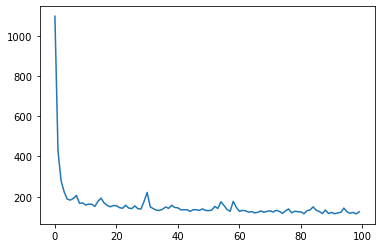

In [137]:
plt.plot(np.array(history_2.history['loss']))

In [138]:
# evaluate model on test data
model_2.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 603.2652


603.2651977539062

In [140]:
# Make predictions using model_1 on the test dataset and view the results
model_2_preds = make_preds(model_2,test_windows)
len(model_2_preds),model_2_preds[:10]

(552,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8925.218 , 8946.621 , 8799.93  , 8594.    , 8463.791 , 8365.465 ,
        8297.2   , 8174.8975, 8225.046 , 7842.946 ], dtype=float32)>)

In [141]:
# Evaluate preds
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                y_pred=model_2_preds)
model_2_results

{'mae': 603.2652,
 'mse': 1261798.2,
 'rmse': 1123.298,
 'mape': 2.747478,
 'mase': 1.0545135}

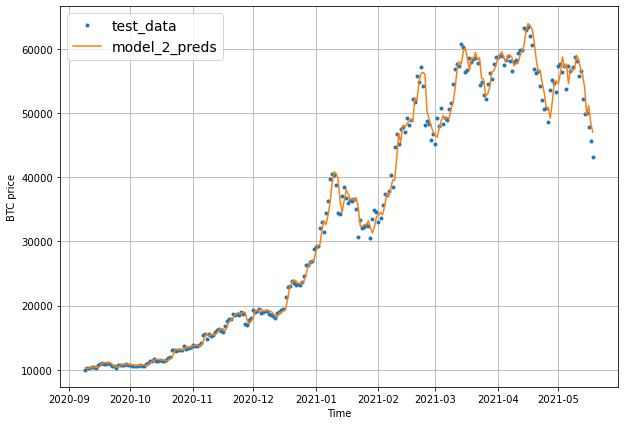

In [147]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds") 

## Model 3: Dense (window = 30, horizon = 7)

Let's try and predict 7 days ahead given the previous 30 days.

First, we'll update the `HORIZON` and `WINDOW_SIZE` variables and create windowed data.


In [148]:
HORIZON = 7 # predict 7 step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
print(f'full_windows ',full_windows.shape)
print(f'full_labels ',full_labels.shape)

# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
print(f'train_windows: ',train_windows.shape)
print(f'test_windows: ',test_windows.shape)
print(f'train_labels: ',train_labels.shape)
print(f'test_labels: ',test_labels.shape)

full_windows  (2751, 30)
full_labels  (2751, 7)
train_windows:  (2200, 30)
test_windows:  (551, 30)
train_labels:  (2200, 7)
test_labels:  (551, 7)


In [169]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

history_3 = model_3.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

INFO:tensorflow:Assets written to: model_exp\model_3_dense\assets
INFO:tensorflow:Assets written to: model_exp\model_3_dense\assets
INFO:tensorflow:Assets written to: model_exp\model_3_dense\assets
INFO:tensorflow:Assets written to: model_exp\model_3_dense\assets
INFO:tensorflow:Assets written to: model_exp\model_3_dense\assets
INFO:tensorflow:Assets written to: model_exp\model_3_dense\assets
INFO:tensorflow:Assets written to: model_exp\model_3_dense\assets
INFO:tensorflow:Assets written to: model_exp\model_3_dense\assets
INFO:tensorflow:Assets written to: model_exp\model_3_dense\assets
INFO:tensorflow:Assets written to: model_exp\model_3_dense\assets
INFO:tensorflow:Assets written to: model_exp\model_3_dense\assets
INFO:tensorflow:Assets written to: model_exp\model_3_dense\assets
INFO:tensorflow:Assets written to: model_exp\model_3_dense\assets
INFO:tensorflow:Assets written to: model_exp\model_3_dense\assets
INFO:tensorflow:Assets written to: model_exp\model_3_dense\assets
INFO:tenso

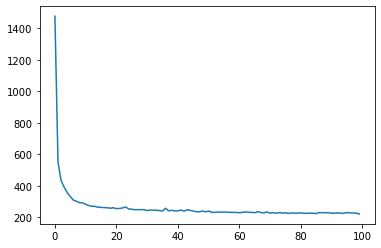

In [152]:
plt.plot(np.array(history_3.history['loss']))

In [153]:
# evaluate model on test data
model_3.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1305.8850


1305.885009765625

In [155]:
# Make predictions using model_1 on the test dataset and view the results
model_3_preds = make_preds(model_3,test_windows)
len(model_3_preds),model_3_preds[:10]

(551,
 <tf.Tensor: shape=(10, 7), dtype=float32, numpy=
 array([[9058.554 , 9100.31  , 9044.279 , 9179.509 , 9193.741 , 9182.645 ,
         9230.27  ],
        [8745.223 , 8846.851 , 8805.262 , 8777.596 , 8792.433 , 8777.62  ,
         9003.1875],
        [8659.82  , 8786.101 , 8680.18  , 8661.268 , 8725.664 , 8619.935 ,
         8901.747 ],
        [8863.66  , 8825.429 , 8647.973 , 8857.915 , 8786.457 , 8830.577 ,
         8951.352 ],
        [8792.389 , 8803.327 , 8535.7   , 8755.818 , 8926.614 , 8885.827 ,
         8827.533 ],
        [8785.603 , 8860.953 , 8624.993 , 8837.754 , 8848.023 , 8815.292 ,
         8835.449 ],
        [8624.727 , 8837.495 , 8694.175 , 8704.937 , 8519.078 , 8651.876 ,
         8736.725 ],
        [8413.869 , 8568.573 , 8495.856 , 8494.844 , 8406.802 , 8313.683 ,
         8494.631 ],
        [8391.819 , 8321.194 , 8325.949 , 8360.427 , 8307.358 , 8210.894 ,
         8330.167 ],
        [8477.68  , 8372.811 , 8219.686 , 8411.363 , 8221.149 , 8179.884 ,
     

In [157]:
# Calculate model_3 results - these are going to be multi-dimensional because
# we're trying to predict more than one step at a time.
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([ 358.65945 ,  151.95592 ,  183.62416 ,  225.75656 ,  269.9022  ,
         338.57666 ,  324.30664 ,  275.09283 ,  364.91315 ,  461.95438 ,
         612.8757  ,  555.6326  ,  576.9677  ,  642.523   ,  411.25238 ,
         177.62619 ,  221.9126  ,  367.95004 ,  403.66156 ,  435.48502 ,
         201.40974 ,  142.28328 ,  116.81445 ,  145.48221 ,  119.091934,
         169.73766 ,  208.3651  ,  215.36809 ,  173.90193 ,   72.24421 ,
         157.95787 ,  220.57674 ,  137.44748 ,  201.57764 ,  187.86635 ,
         203.51695 ,  213.57317 ,  184.01283 ,  234.12424 ,  376.11307 ,
         598.2387  ,  301.4504  ,  197.08963 ,  241.7906  ,   88.44622 ,
         170.76877 ,  138.2606  ,  123.9421  ,   94.37214 ,  173.41121 ,
         131.64139 ,  120.71156 ,  108.51458 ,  141.50488 ,  372.47754 ,
         498.8475  ,  707.05817 ,  691.50793 ,  659.66797 ,  675.5074  ,
         580.48016 ,  385.4854  ,  356.22928 ,  475.77505 ,  606.64124 ,
         622.38605 ,  668.89984 ,  692.66833

## Make our evaluation function work for larger horizons

You'll notice the outputs for `model_3_results` are multi-dimensional. 

This is because the predictions are getting evaluated across the `HORIZON` timesteps (7 predictions at a time).

To fix this, let's adjust our `evaluate_preds()` function to work with multiple shapes of data.

In [161]:
def evaluate_preds(y_true,y_pred):
    # make sure float32 (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    # calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true,y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true,y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
    mase = mean_absolute_scaled_error(y_true,y_pred)
    
    # account for different sized metrics (for longer horizons, reduce to single number)
    # if mae is not already a scalar, reduce it to one by aggregating tensors to mean
    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)
        
    return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}
        

Now we've updated `evaluate_preds()` to work with multiple shapes, how does it look?

In [162]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1305.8849,
 'mse': 5629179.0,
 'rmse': 1482.9333,
 'mape': 5.7518477,
 'mase': 2.323749}

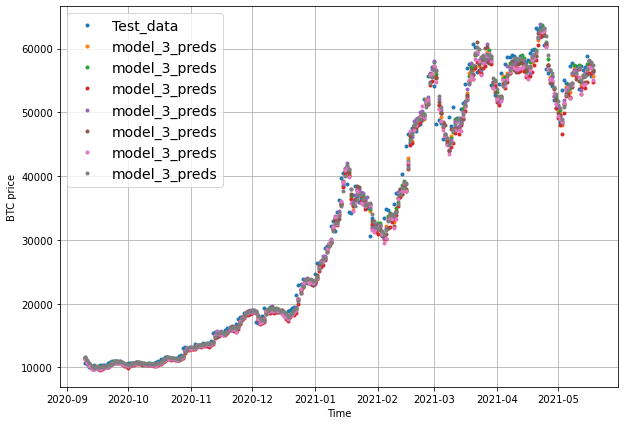

In [163]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

When we try to plot our multi-horizon predicts, we get a funky looking plot.

Again, we can fix this by aggregating our model's predictions.

> 🔑 **Note:** Aggregating the predictions (e.g. reducing a 7-day horizon to one value such as the mean) loses information from the original prediction. As in, the model predictions were trained to be made for 7-days but by reducing them to one, we gain the ability to plot them visually but we lose the extra information contained across multiple days.

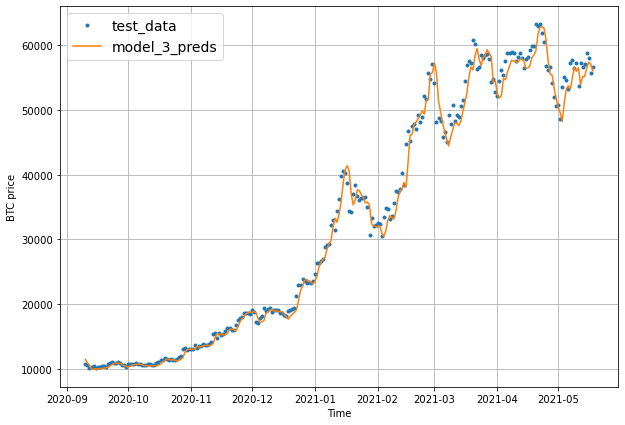

In [167]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds,axis=1), start=offset, format="-", label="model_3_preds") 

## Which of our models is performing best so far?

So far, we've trained 3 models which use the same architecture but use different data inputs.

Let's compare them with the naïve model to see which model is performing the best so far.

<AxesSubplot:>

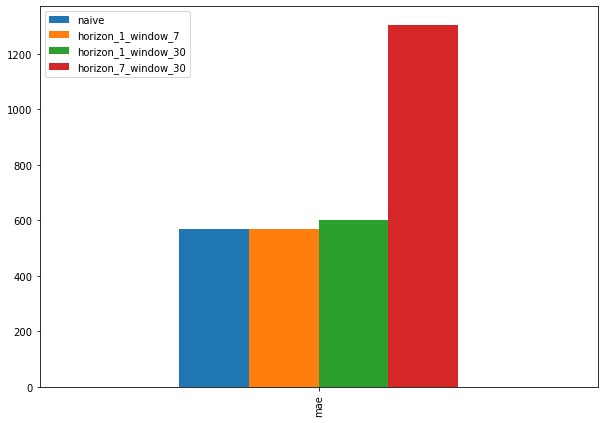

In [168]:
pd.DataFrame({'naive':naive_results['mae'],
            'horizon_1_window_7':model_1_results['mae'],
             'horizon_1_window_30':model_2_results['mae'],
             'horizon_7_window_30':model_3_results['mae']},
             index=['mae']
            ).plot(figsize=(10,7),kind='bar')

Woah, our naïve model is performing best (it's very hard to beat a naïve model in open systems) but the dense model with a horizon of 1 and a window size of 7 looks to be performing cloest.

Because of this, let's use `HORIZON=1` and `WINDOW_SIZE=7` for our next series of modelling experiments (in other words, we'll use the previous week of Bitcoin prices to try and predict the next day).

> 🔑 **Note:** You might be wondering, why are the naïve results so good? One of the reasons could be due the presence of **autocorrelation** in the data. If a time series has **autocorrelation** it means the value at `t+1` (the next timestep) is typically close to the value at `t` (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is, a naïve model will often get fairly good results.

> 📖 **Resource:** For more on how autocorrelation influences a model's predictions, see the article [*How (not) to use Machine Learning for time series forecasting: Avoiding the pitfalls*](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424) by Vegard Flovik

## Model 4: Conv1D

Onto the next modelling experiment!

This time, we'll be using a Conv1D model. Because as we saw in the sequence modelling notebook, Conv1D models can be used for seq2seq (sequence to sequence) problems.

In our case, the input sequence is the previous 7 days of Bitcoin price data and the output is the next day (in seq2seq terms this is called a many to one problem).

![bitcoin prediction in seq2seq terms](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-bitcoin-forecast-in-seq2seq-terms.png)
*Framing Bitcoin forecasting in seq2seq (sequence to sequence) terms. Using a window size of 7 and a horizon of one results in a many to one problem. Using a window size of >1 and a horizon of >1 results in a many to many problem. The diagram comes from Andrei Karpathy's [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)*.

Before we build a Conv1D model, let's recreate our datasets.

In [172]:
HORIZON = 1 # predict step at a time
WINDOW_SIZE = 7 # use 30 timesteps in the past

# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
print(f'full_windows ',full_windows.shape)
print(f'full_labels ',full_labels.shape)

# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
print(f'train_windows: ',train_windows.shape)
print(f'test_windows: ',test_windows.shape)
print(f'train_labels: ',train_labels.shape)
print(f'test_labels: ',test_labels.shape)

full_windows  (2780, 7)
full_labels  (2780, 1)
train_windows:  (2224, 7)
test_windows:  (556, 7)
train_labels:  (2224, 1)
test_labels:  (556, 1)


Data windowed!

Now, since we're going to be using [Conv1D layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D), we need to make sure our input shapes are correct.

The Conv1D layer in TensorFlow takes an input of: `(batch_size, timesteps, input_dim)`.

In our case, the `batch_size` (by default this is 32 but we can change it) is handled for us but the other values will be:
* `timesteps = WINDOW_SIZE` - the `timesteps` is also often referred to as `features`, our features are the previous `WINDOW_SIZE` values of Bitcoin 
* `input_dim = HORIZON` - our model views `WINDOW_SIZE` (one week) worth of data at a time to predict `HORIZON` (one day)

Right now, our data has the `timesteps` dimension ready but we'll have to adjust it to have the `input_dim` dimension. 

In [173]:
# Check data sample shapes
train_windows[0].shape # return (WINDOW_SIZE,)

(7,)

To fix this, we could adjust the shape of all of our `train_windows` or we could use a [`tf.keras.layers.Lamdba`](https://keras.io/api/layers/core_layers/lambda/) (called a Lambda layer) to do this for us in our model.

The Lambda layer wraps a function into a layer which can be used with a model.

Let's try it out.

In [175]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x,axis=1)) # add an extra dimension for timesteps
print(f'Original shape: {x.shape}') # (WINDOW_SIZE)
print(f'Expanded shape: {expand_dims_layer(x).shape}') # (WINDOW_SIZE,input_dim)
print(f'Original values with expanded shape:\n {expand_dims_layer(x)}')

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


Looking good!

Now we've got a Lambda layer, let's build, compile, fit and evaluate a Conv1D model on our data.

> 🔑 **Note:** If you run the model below without the Lambda layer, you'll get an input shape error (one of the most common errors when building neural networks).

In [185]:
tf.random.set_seed(42)

# create model
model_4 = tf.keras.Sequential([
    # create Lambda layer to reshape inputs, without this layer the model will error
    layers.Lambda(lambda x:tf.expand_dims(x,axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
    layers.Conv1D(filters=128,kernel_size=5,padding='causal',activation='relu'),
    layers.Dense(HORIZON)],name='model_4_conv1D')

# compile model
model_4.compile(loss='mae',
               optimizer=tf.keras.optimizers.Adam())

# Fit model
history_4 = model_4.fit(train_windows,
           train_labels,
           batch_size=128,
           epochs=100,
           verbose=0,
           validation_data=(test_windows,test_labels),
           callbacks=[create_model_checkpoint(model_name=model_4.name)])

model_4.summary()

INFO:tensorflow:Assets written to: model_exp\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_exp\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_exp\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_exp\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_exp\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_exp\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_exp\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_exp\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_exp\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_exp\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_exp\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_exp\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_exp\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_exp\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_exp\model_4_conv1D\as

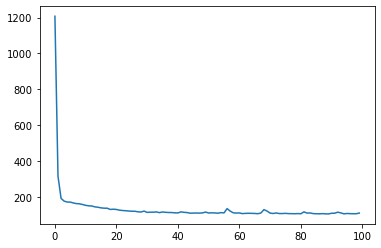

In [186]:
plt.plot(np.array(history_4.history['loss']))

In [188]:
# evaluate model on test data
model_4.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 624.1893


624.1892700195312

In [195]:
# Make predictions using model_1 on the test dataset and view the results
model_4_preds = make_preds(model_4,test_windows)
len(model_4_preds),model_4_preds[:10]

(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8757.926, 8672.435, 8909.878, 8677.156, 8626.225, 8629.011,
        8571.999, 8412.18 , 8359.45 , 8413.409], dtype=float32)>)

In [196]:
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 624.1893,
 'mse': 1271775.8,
 'rmse': 1127.7303,
 'mape': 2.8304513,
 'mase': 1.0965277}

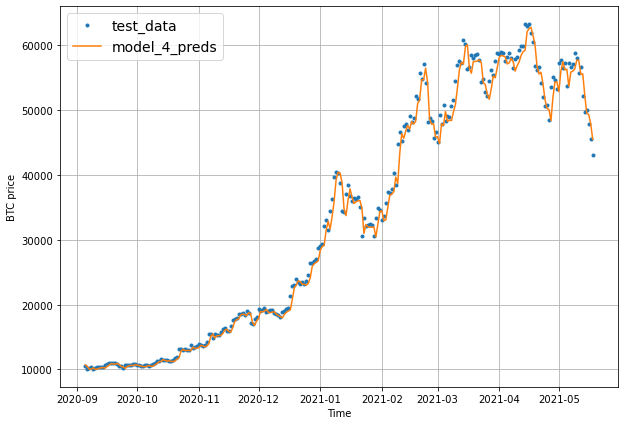

In [198]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_4_preds, start=offset, format="-", label="model_4_preds") 

## Model 5: RNN (LSTM)

As you might've guessed, we can also use a recurrent neural network to model our sequential time series data.

> 📖 **Resource:** For more on the different types of recurrent neural networks you can use for sequence problems, see the [Recurrent Neural Networks section of notebook 08](https://dev.mrdbourke.com/tensorflow-deep-learning/08_introduction_to_nlp_in_tensorflow/#recurrent-neural-networks-rnns).

Let's reuse the same data we used for the Conv1D model, except this time we'll create an [LSTM-cell](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) powered RNN to model our Bitcoin data. 

Once again, one of the most important steps for the LSTM model will be getting our data into the right shape.

The [`tf.keras.layers.LSTM()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) layer takes a tensor with `[batch, timesteps, feature]` dimensions.

As mentioned earlier, the `batch` dimension gets taken care of for us but our data is currently only has the `feature` dimension (`WINDOW_SIZE`).

To fix this, just like we did with the `Conv1D` model, we can use a `tf.keras.layers.Lambda()` layer to adjust the shape of our input tensors to the LSTM layer.


In [203]:
tf.random.set_seed(42)

# let build an LSTM model with the functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x:tf.expand_dims(x,axis=1))(inputs)# expand input dimension to be compatible with LSTM
x = layers.LSTM(128,activation='relu')(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs,outputs=output,name='model_5_lstm')

# compile model
model_5.compile(loss='mae',
               optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
history_5 = model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

model_5.summary()

INFO:tensorflow:Assets written to: model_exp\model_5_lstm\assets
INFO:tensorflow:Assets written to: model_exp\model_5_lstm\assets
INFO:tensorflow:Assets written to: model_exp\model_5_lstm\assets
INFO:tensorflow:Assets written to: model_exp\model_5_lstm\assets
INFO:tensorflow:Assets written to: model_exp\model_5_lstm\assets
INFO:tensorflow:Assets written to: model_exp\model_5_lstm\assets
INFO:tensorflow:Assets written to: model_exp\model_5_lstm\assets
INFO:tensorflow:Assets written to: model_exp\model_5_lstm\assets
INFO:tensorflow:Assets written to: model_exp\model_5_lstm\assets
INFO:tensorflow:Assets written to: model_exp\model_5_lstm\assets
INFO:tensorflow:Assets written to: model_exp\model_5_lstm\assets
INFO:tensorflow:Assets written to: model_exp\model_5_lstm\assets
INFO:tensorflow:Assets written to: model_exp\model_5_lstm\assets
INFO:tensorflow:Assets written to: model_exp\model_5_lstm\assets
INFO:tensorflow:Assets written to: model_exp\model_5_lstm\assets
INFO:tensorflow:Assets wr

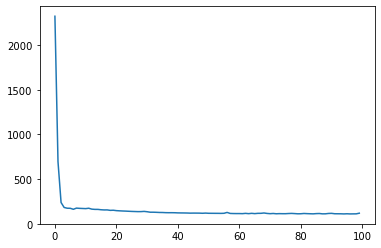

In [207]:
plt.plot(np.array(history_5.history['loss']))

18/18 [==============================] - 0s 3ms/step - loss: 668.3491
model evaluate 668.34912109375
model result {'mae': 668.34924, 'mse': 1442477.9, 'rmse': 1201.032, 'mape': 3.1153479, 'mase': 1.1741045}


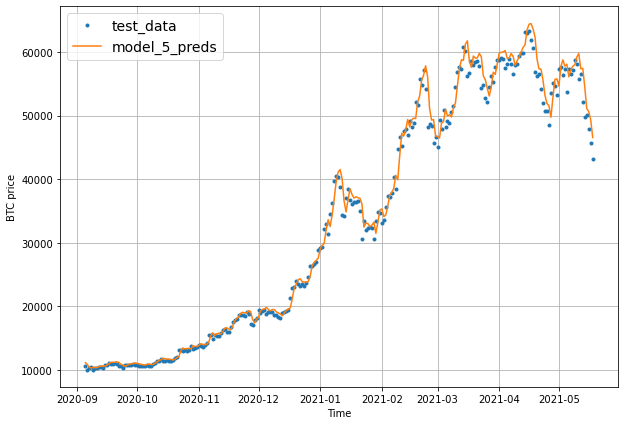

In [208]:
# evaluate model on test data
print('model evaluate',model_5.evaluate(test_windows,test_labels))

# Make predictions using model_1 on the test dataset and view the results
model_5_preds = make_preds(model_5,test_windows)

model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)

print(f'model result',model_5_results)

offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_5_preds, start=offset, format="-", label="model_5_preds") 

## Make a multivariate time series 

So far all of our models have barely kept up with the naïve forecast.

And so far all of them have been trained on a single variable (also called univariate time series): the historical price of Bitcoin.

If predicting the price of Bitcoin using the price of Bitcoin hasn't worked out very well, maybe giving our model more information may help.

More information is a vague term because we could actually feed almost anything to our model(s) and they would still try to find patterns. 

For example, we could use the historical price of Bitcoin as well as anyone with the name [Daniel Bourke Tweeted](https://twitter.com/mrdbourke) on that day to predict the future price of Bitcoin.

But would this help?

Porbably not.

What would be better is if we passed our model something related to Bitcoin (again, this is quite vauge, since in an open system like a market, you could argue everything is related).

This will be different for almost every time series you work on but in our case, we could try to see if the [Bitcoin block reward size](https://www.investopedia.com/terms/b/block-reward.asp) adds any predictive power to our model(s).

What is the Bitcoin block reward size?

The Bitcoin block reward size is the number of Bitcoin someone receives from mining a Bitcoin block.

At its inception, the Bitcoin block reward size was 50.

But every four years or so, the Bitcoin block reward halves.

For example, the block reward size went from 50 (starting January 2009) to 25 on November 28 2012.

Let's encode this information into our time series data and see if it helps a model's performance.

> 🔑 **Note:** Adding an extra feature to our dataset such as the Bitcoin block reward size will take our data from **univariate** (only the historical price of Bitcoin) to **multivariate** (the price of Bitcoin as well as the block reward size).

In [209]:
# let's make multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


Alright, time to add another feature column, the block reward size.

First, we'll need to create variables for the different block reward sizes as well as the dates they came into play.

The following block rewards and dates were sourced from [cmcmarkets.com](https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving).

| Block Reward | Start Date |
| ----- | ----- |
| 50 | 3 January 2009 (2009-01-03) |
| 25 | 28 November 2012 |
| 12.5 | 9 July 2016 |
| 6.25 | 11 May 2020 |
| 3.125 | TBA (expected 2024) |
| 1.5625 | TBA (expected 2028) | 

> 🔑 **Note:** Since our Bitcoin historical data starts from 01 October 2013, none of the timesteps in our multivariate time series will have a block reward of 50.

We're going to get the days (indexes) for different block reward values. 

This is important because if we're going to use multiple variables for our time series, they have to the same frequency as our original variable. For example, if our Bitcoin prices are daily, we need the block reward values to be daily as well.

> 🔑 **Note:** For using multiple variables, make sure they're the same frequency as each other. If your variables aren't at the same frequency (e.g. Bitcoin prices are daily but block rewards are weekly), you may need to transform them in a way that they can be used with your model.

In [211]:
# Block reward values
block_reward_1 = 50
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 = 6.25

# block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [214]:
# Get date indexes for when to add fifferent block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [220]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block['block_reward']= None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days,-1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days,-1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:,-1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


<AxesSubplot:xlabel='Date'>

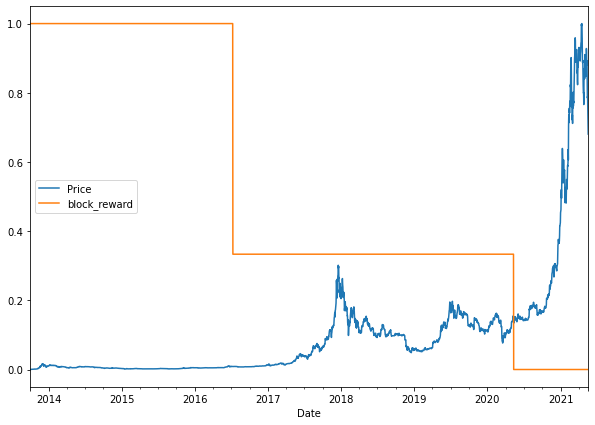

In [221]:
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
from sklearn.preprocessing import minmax_scale

scaled_priced_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[['Price','block_reward']]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                      index=bitcoin_prices_block.index)

# plot
scaled_priced_block_df.plot(figsize=(10,7))

When we scale the block reward and the Bitcoin price, we can see the price goes up as the block reward goes down, perhaps this information will be helpful to our model's performance.

## Making a windowed dataset with pandas

Previously, we used some custom made functions to window our **univariate** time series.

However, since we've just added another variable to our dataset, these functions won't work.

Not to worry though. Since our data is in a pandas DataFrame, we can leverage the [`pandas.DataFrame.shift()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html) method to create a windowed **multivariate** time series.

The `shift()` method offsets an index by a specified number of periods.

Let's see it in action.

In [223]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [226]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
# Shift values for each step in WINDOW_SIZE
for i in range(WINDOW_SIZE):
    bitcoin_prices_windowed[f'Price+{i+1}'] = bitcoin_prices_windowed['Price'].shift(periods=i+1)

bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


Now that we've got a windowed dataset, let's separate features (`X`) from labels (`y`).

Remember in our windowed dataset, we're trying to use the previous `WINDOW_SIZE` steps to predict `HORIZON` steps.

```
Window for a week (7) to predict a horizon of 1 (multivariate time series)
WINDOW_SIZE & block_reward -> HORIZON

[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

We'll also remove the `NaN` values using pandas [`dropna()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) method, this equivalent to starting our windowing function at `sample 0 (the first sample) + WINDOW_SIZE`.

In [250]:
# Let's create X & y, remove the NaN's and covert to float32 to prevent tensorflow errors
X = bitcoin_prices_windowed.dropna().drop("Price",axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [251]:
# View labels
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

What a good looking dataset, let's split it into train and test sets using an 80/20 split just as we've done before.

In [252]:
# Make train and test sets
split_size = int(len(X)*0.8)
X_train,y_train = X[:split_size],y[:split_size]
X_test,y_test = X[split_size:],y[split_size:]
print(f'X_train ',X_train.shape)
print(f'X_test ',X_test.shape)
print(f'y_train ',y_train.shape)
print(f'y_test ',y_test.shape)

X_train  (2224, 8)
X_test  (556, 8)
y_train  (2224,)
y_test  (556,)


## Model 6: Dense (multivariate time series)

To keep things simple, let's the `model_1` architecture and use it to train and make predictions on our multivariate time series data.

By replicating the `model_1` architecture we'll be able to see whether or not adding the block reward feature improves or detracts from model performance.

In [253]:
tf.random.set_seed(42)

# Make multivariate time
model_6 = tf.keras.Sequential([
    layers.Dense(128,activation='relu'),
    layers.Dense(HORIZON)],name='model_6_dense_multivariate')

# compile
model_6.compile(loss='mae',optimizer=tf.keras.optimizers.Adam())

# fit
history_6= model_6.fit(X_train,y_train,
           epochs=100,
           batch_size=128,
           verbose=0,
           validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

model_6.summary()

INFO:tensorflow:Assets written to: model_exp\model_6_dense_multivariate\assets
INFO:tensorflow:Assets written to: model_exp\model_6_dense_multivariate\assets
INFO:tensorflow:Assets written to: model_exp\model_6_dense_multivariate\assets
INFO:tensorflow:Assets written to: model_exp\model_6_dense_multivariate\assets
INFO:tensorflow:Assets written to: model_exp\model_6_dense_multivariate\assets
INFO:tensorflow:Assets written to: model_exp\model_6_dense_multivariate\assets
INFO:tensorflow:Assets written to: model_exp\model_6_dense_multivariate\assets
INFO:tensorflow:Assets written to: model_exp\model_6_dense_multivariate\assets
INFO:tensorflow:Assets written to: model_exp\model_6_dense_multivariate\assets
INFO:tensorflow:Assets written to: model_exp\model_6_dense_multivariate\assets
INFO:tensorflow:Assets written to: model_exp\model_6_dense_multivariate\assets
INFO:tensorflow:Assets written to: model_exp\model_6_dense_multivariate\assets
INFO:tensorflow:Assets written to: model_exp\model_6

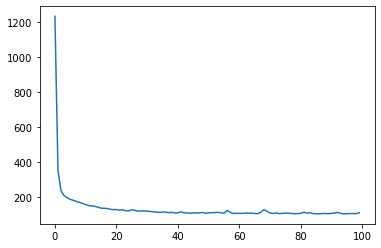

In [255]:
plt.plot(np.array(history_6.history['loss']))

Multivariate model fit!

You might've noticed that the model inferred the input shape of our data automatically (the data now has an extra feature). Often this will be the case, however, if you're running into shape issues, you can always explicitly define the input shape using `input_shape` parameter of the first layer in a model.

Time to evaluate our multivariate model.

In [256]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model('model_exp/model_6_dense_multivariate')
model_6.evaluate(X_test,y_test)

18/18 [==============================] - 0s 2ms/step - loss: 568.4507


568.4507446289062

In [257]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8854.942, 8783.565, 9061.757, 8759.421, 8737.176, 8784.184,
       8680.546, 8514.702, 8481.645, 8540.754], dtype=float32)>

In [258]:
y_test

Date
2019-11-10     8798.041992
2019-11-11     9081.186523
2019-11-12     8711.534180
2019-11-13     8760.892578
2019-11-14     8749.520508
                  ...     
2021-05-14    49764.132812
2021-05-15    50032.691406
2021-05-16    47885.625000
2021-05-17    45604.617188
2021-05-18    43144.472656
Name: Price, Length: 556, dtype: float32

In [259]:
# Evaluate preds
model_6_results = evaluate_preds(y_true=y_test,
                                y_pred=model_6_preds)

model_6_results

{'mae': 568.45074,
 'mse': 1166161.5,
 'rmse': 1079.8895,
 'mape': 2.5497832,
 'mase': 0.9986105}

It looks like the adding in the block reward may have helped our model slightly.

But there a few more things we could try.

> 📖 **Resource:** For different ideas on how to improve a neural network model (from a model perspective), refer to the [*Improving a model*](https://dev.mrdbourke.com/tensorflow-deep-learning/02_neural_network_classification_in_tensorflow/#improving-a-model) section in notebook 02.


> 🛠 **Exercise(s):** 
> 1. Try adding an extra `tf.keras.layers.Dense()` layer with 128 hidden units to `model_6`, how does this effect model performance?
> 2. Is there a better way to create this model? As in, should the `block_reward` feature be bundled in with the Bitcoin historical price feature? Perhaps you could test whether building a multi-input model (e.g. one model input for Bitcoin price history and one model input for `block_reward`)  works better? See [*Model 4: Hybrid embedding*](https://dev.mrdbourke.com/tensorflow-deep-learning/09_SkimLit_nlp_milestone_project_2/#model-4-combining-pretrained-token-embeddings-character-embeddings-hybrid-embedding-layer) section of notebook 09 for an idea on how to create a multi-input model.

## Model 7: N-BEATS algorithm

Time to step things up a notch.

So far we've tried a bunch of smaller models, models with only a couple of layers.

But one of the best ways to improve a model's performance is to increase the number of layers in it.

That's exactly what the [N-BEATS (Neural Basis Expansion Analysis for Interpretable Time Series Forecasting) algorithm](https://arxiv.org/pdf/1905.10437.pdf) does.

The N-BEATS algorithm focuses on univariate time series problems and achieved state-of-the-art performance in the winner of the [M4 competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128) (a forecasting competition).

For our next modelling experiment we're going to be replicating the **generic architecture** of the N-BEATS algorithm (see [section 3.3 of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)).

We're not going to go through all of the details in the paper, instead we're going to focus on:
1. Replicating the model architecture in [Figure 1 of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf) 

![figure 1 from N-BBEATS paper, the algorithm we're going to build](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-figure-1-nbeats-paper-annotated.png)
*N-BEATS algorithm we're going to replicate with TensorFlow with window (input) and horizon (output) annotations.*

2. Using the same hyperparameters as the paper which can be found in [Appendix D of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)

Doing this will give us an opportunity to practice:
* Creating a custom layer for the `NBeatsBlock` by subclassing [`tf.keras.layers.Layer`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer)
  * Creating a custom layer is helpful for when TensorFlow doesn't already have an existing implementation of a layer or if you'd like to make a layer configuration repeat a number of times (e.g. like a stack of N-BEATS blocks)
* Implementing a custom architecture using the Functional API 
* Finding a paper related to our problem and seeing how it goes 

> 🔑 **Note:** As you'll see in the paper, the authors state “N-BEATS is implemented and trained in TensorFlow”, that's what we'll be doing too!

### Building and testing an N-BEATS block layer

Let's start by building an N-BEATS block layer, we'll write the code first and then discuss what's going on.

In [262]:
# Create NBeatBlock custom layer
class NBeatBlock(tf.keras.layers.Layer):
    def __init__(self, # the constructor takes all the hyperparameters for the layer
                 input_size: int,
                 theta_size: int,
                 horizon: int,
                 n_neurons: int,
                 n_layers:int,
                 **kwargs # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
                ):
        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_dize = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers
        
        # block contains stack of 4 fully conntected layers each has relu activation
        self.hidden = [tf.keras.layers.Dense(n_neurons,activation='relu') for _ in range(n_layers)]
        # output of block is theta layer with linear activation
        self.theta_layer = tf.keras.layers.Dense(theta_size,activation='linear',name='theta')
    
    def call(self,inputs): # the call method is what runs when the layer is called
        x = inputs
        for layer in self.hidden: # pass inputs through each hidden layer
            x = layer(x)
        theta = self.theta_layer(x)
        # output the backcast and forecast from theta
        backcast,forecast = theta[:,:self.input_size],theta[:,-self.horizon:]
        return backcast,forecast

Setting up the `NBeatsBlock` custom layer we see: 
* The class inherits from `tf.keras.layers.Layer` (this gives it all of the methods assosciated with `tf.keras.layers.Layer`)
* The constructor (`def __init__(...)`) takes all of the layer hyperparameters as well as the `**kwargs` argument
  * The `**kwargs` argument takes care of all of the hyperparameters which aren't mentioned in the constructor such as, `input_shape`, `trainable` and `name`
* In the constructor, the block architecture layers are created:
  * The hidden layers are created as a stack of fully connected with `n_nuerons` hidden units layers with ReLU activation
  * The theta layer uses `theta_size` hidden units as well as linear activation
* The `call()` method is what is run when the layer is called:
  * It first passes the inputs (the historical Bitcoin data) through each of the hidden layers (a stack of fully connected layers with ReLU activation)
  * After the inputs have been through each of the fully connected layers, they get passed through the theta layer where the backcast (backwards predictions, shape: `input_size`) and forecast (forward predictions, shape: `horizon`) are returned

![code mapping to image of N-BEATS basic block](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-basic-block-replication-with-tensorflow-layer-subclassing.png)
*Using TensorFlow layer subclassing to replicate the N-BEATS basic block. See section 3.1 of N-BEATS paper for details.*

Let's see our block replica in action by together by creating a toy version of `NBeatsBlock`.

> 📖  **Resource:** Much of the creation of the time series materials (the ones you're going through now), including replicating the N-BEATS algorithm were streamed live on Twitch. If you'd like to see replays of how the algorithm was replicated, check out the [*Time series research and TensorFlow course material creation playlist*](https://youtube.com/playlist?list=PL8IpyNZ21vUSCM7nRAuS-hW_E-sgwdmaI) on the Daniel Bourke arXiv YouTube channel.

In [263]:
# Set up dummy NBeatBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatBlock(input_size=WINDOW_SIZE,
                                     theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                     horizon=HORIZON,
                                      n_neurons = 128,
                                      n_layers=4
                                     )

In [264]:
# Create dummy inputs (have to be same size input size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE)+1,axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]])>

In [265]:
# Pass dummy inputs to dummy NBeatBlock layer
backcast,forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they will be random due to no training of the model)
print(f'Backcast: {tf.squeeze(backcast.numpy())}')
print(f'Forecast: {tf.squeeze(forecast.numpy())}')

Backcast: [ 0.19014972  0.8379835  -0.32870024  0.2515991  -0.47540277 -0.7783665
 -0.52994466]
Forecast: -0.7554213404655457


### Preparing data for the N-BEATS algorithm using `tf.data`

We've got the basic building block for the N-BEATS architecture ready to go.

But before we use it to replicate the entire N-BEATS generic architecture, let's create some data.

This time, because we're going to be using a larger model architecture, to ensure our model training runs as fast as possible, we'll setup our datasets using the `tf.data` API.

And because the N-BEATS algorithm is focused on univariate time series, we'll start by making training and test windowed datasets of Bitcoin prices (just as we've done above).


In [266]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

# Create NBEATS data inputs (NBEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [268]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
    bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [269]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

Train and test sets ready to go!

Now let's convert them into TensorFlow `tf.data.Dataset`'s to ensure they run as fast as possible whilst training.

We'll do this by:
1. Turning the arrays in tensor Datasets using [`tf.data.Dataset.from_tensor_slices()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices)
  * Note: `from_tensor_slices()` works best when your data fits in memory, for extremely large datasets, you'll want to look into using the [`TFRecord` format](https://www.tensorflow.org/tutorials/load_data/tfrecord)
2. Combine the labels and features tensors into a Dataset using [`tf.data.Dataset.zip()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#zip)
3. Batch and prefetch the Datasets using [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch)
  * Batching and prefetching ensures the loading time from CPU (preparing data) to GPU (computing on data) is as small as possible 

> 📖 **Resource:** For more on building highly performant TensorFlow data pipelines, I'd recommend reading through the [*Better performance with the tf.data API*](https://www.tensorflow.org/guide/data_performance) guide.

In [274]:
# 1 Turn train and test array into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)
test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2 Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset,train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset,test_labels_dataset))

# 3 Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendiz D in N-BEATs paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>,
 <PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>)

Data prepared! Notice the input shape for the features `(None, 7)`, the `None` leaves space for the batch size where as the `7` represents the `WINDOW_SIZE`.

Time to get create the N-BEATS architecture. 

### Setting up hyperparameters for N-BEATS algorithm

Ho ho, would you look at that! Datasets ready, model building block ready, what'd you say we put things together?

Good idea.

Okay.

Let's go.

To begin, we'll create variables for each of the hyperparameters we'll be using for our N-BEATS replica.

> 📖 **Resource:** The following hyperparameters are taken from Figure 1 and Table 18/Appendix D of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf).

![table 18 from N-BEATS paper](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-table-18-hyperparameters.png)
*Table 18 from [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf) describing the hyperparameters used for the different variants of N-BEATS. We're using N-BEATS-G which stands for the generic version of N-BEATS.*

> 🔑 **Note:** If you see variables in a machine learning example in all caps, such as "`N_EPOCHS = 100`", these variables are often hyperparameters which are used through the example. You'll usually see them instantiated towards the start of an experiment and then used throughout.



In [276]:
# Values from N-BEATS paper figure 1 and table 18/Appendix D
N_EPOCHS= 5000 # called "Iterations" in table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30
INPUT_SIZE = WINDOW_SIZE * HORIZON # called "lookback" in table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE,THETA_SIZE

(7, 8)

### Getting ready for residual connections

Beautiful! Hyperparameters ready, now before we create the N-BEATS model, there are two layers to go through which play a large roll in the architecture.

They're what make N-BEATS **double residual stacking** (section 3.2 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)) possible:
* [`tf.keras.layers.subtract(inputs)`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/subtract) - subtracts list of input tensors from each other
* [`tf.keras.layers.add(inputs)`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/add) - adds list of input tensors to each other

Let's try them out.

In [285]:
# Make tensors
tensor_1 = tf.range(10)+10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1,tensor_2])

# Add
added = layers.add([tensor_1,tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


Both of these layer functions are straight-forward, subtract or add together their inputs.

And as mentioned before, they're what powers N-BEATS double residual stacking.

The power of **residual stacking** or **residual connections** was revealed in [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) where the authors were able to build a deeper but less complex neural network (this is what introduced the popular [ResNet architecture](https://en.wikipedia.org/wiki/Residual_neural_network)) than previous attempts. 

This deeper neural network led to state of the art results on the ImageNet challenge in 2015 and different versions of residual connections have been present in deep learning ever since.

> What is a residual connection?

A **residual connection** (also called skip connections) involves a deeper neural network layer receiving the outputs as well as the inputs of a shallower neural network layer.

In the case of N-BEATS, the architecture uses residual connections which:
* Subtract the backcast outputs from a previous block from the backcast inputs to the current block
* Add the forecast outputs from all blocks together in a stack 

![N-BEATS architecture double residual stacking](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-architecture-double-residual-stacking.png)
*Annotated version of Figure 1 from the N-BEATS paper highlighting the double residual stacking (section 3.2) of the architecture. Backcast residuals of each block are subtracted from each other and used as the input to the next block where as the forecasts of each block are added together to become the stack forecast.*

> What are the benefits of residual connections?

In practice, residual connections have been beneficial for training deeper models (N-BEATS reaches ~150 layers, also see "These approaches provide clear advantages in improving the trainability of deep architectures" in section 3.2 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)).  

It's thought that they help avoid the problem of [vanishing gradients](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) (patterns learned by a neural network not being passed through to deeper layers).



### Building, compiling and fitting the N-BEATS algorithm 

Okay, we've finally got all of the pieces of the puzzle ready for building and training the N-BEATS algorithm.

We'll do so by going through the following:

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional) for this)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use a for loop to create stacks of block layers
5. Use the NBeatsBlock class within the for loop created in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using [`tf.keras.Model()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model)
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default settings as per section 5.2 of [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf))
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  * [`tf.keras.callbacks.EarlyStopping()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - stop the model from training if it doesn't improve validation loss for 200 epochs and restore the best performing weights using `restore_best_weights=True` (this'll prevent the model from training for loooongggggg period of time without improvement)
  * [`tf.keras.callbacks.ReduceLROnPlateau()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau) - if the model's validation loss doesn't improve for 100 epochs, reduce the learning rate by 10x to try and help it make incremental improvements (the smaller the learning rate, the smaller updates a model tries to make)

Woah. A bunch of steps. But I'm sure you're up to it.

Let's do it!

### Building, compiling and fitting the N-BEATS algorithm 

Okay, we've finally got all of the pieces of the puzzle ready for building and training the N-BEATS algorithm.

We'll do so by going through the following:

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional) for this)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use a for loop to create stacks of block layers
5. Use the NBeatsBlock class within the for loop created in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using [`tf.keras.Model()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model)
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default settings as per section 5.2 of [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf))
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  * [`tf.keras.callbacks.EarlyStopping()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - stop the model from training if it doesn't improve validation loss for 200 epochs and restore the best performing weights using `restore_best_weights=True` (this'll prevent the model from training for loooongggggg period of time without improvement)
  * [`tf.keras.callbacks.ReduceLROnPlateau()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau) - if the model's validation loss doesn't improve for 100 epochs, reduce the learning rate by 10x to try and help it make incremental improvements (the smaller the learning rate, the smaller updates a model tries to make)

Woah. A bunch of steps. But I'm sure you're up to it.

Let's do it!

In [289]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

# 1 Setup N-BEATS Block Layer
nbeat_block_layer = NBeatBlock(input_size=INPUT_SIZE,
                               theta_size=THETA_SIZE,
                               horizon=HORIZON,
                               n_neurons=N_NEURONS,
                               n_layers=N_LAYERS,
                               name='InitialBlock')

# 2 Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE),name='stack_input')

# 3 create intial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast,forecast = nbeat_block_layer(stack_input)

# add in subtraction
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4 create stacks o blocks
# first stack is already created in (3)
for i,_ in enumerate(range(N_STACKS-1)):
    
    # 5 Use the NBeatsBlock to calculate the backcast as well as block forecast
    backcast,block_forecast = NBeatBlock(
    input_size=INPUT_SIZE,
    theta_size=THETA_SIZE,
    horizon=HORIZON,
    n_neurons=N_NEURONS,
    n_layers=N_LAYERS,
    name=f'NBeatBlock_{i}'
    )(residuals) # pass it in residuals (the backcast)
    
    # 6 create the double residual stacking
    residuals = layers.subtract([residuals,backcast],name=f'substact_{i}')
    forecast = layers.add([forecast,block_forecast],name=f'add_{i}')
    
# 7 Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input,
                        outputs=forecast,
                        name='model_7_N-BEATS')

# 8 Compile with MAE loss and Adam optimizer
model_7.compile(loss='mae',
               optimizer=tf.keras.optimizers.Adam(0.001),
               metrics=['mae','mse'])

# 9 Fit the model with EarlyStopping and ReduceLROPlateau callbacks
history_7 = model_7.fit(train_dataset,
           epochs=N_EPOCHS,
           validation_data=test_dataset,
           verbose=0,
           callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=200,restore_best_weights=True),
                     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=100,verbose=1)])


Epoch 00145: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00245: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


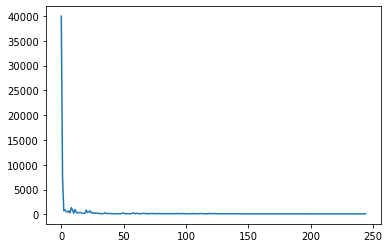

In [290]:
plt.plot(np.array(history_7.history['loss']))

In [291]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 1s 740ms/step - loss: 586.3232 - mae: 586.3232 - mse: 1216148.7500


[586.3231811523438, 586.3231811523438, 1216148.75]

In [292]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8859.247 , 8764.031 , 8948.9375, 8744.674 , 8671.256 , 8668.797 ,
       8655.336 , 8496.341 , 8405.621 , 8469.764 ], dtype=float32)>

In [293]:
# Evaluate N-BEATS model predictions
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 586.3232,
 'mse': 1216148.8,
 'rmse': 1102.7914,
 'mape': 2.6763809,
 'mase': 1.0300075}

Woah... even with all of those special layers and hand-crafted network, it looks like the N-BEATS model doesn't perform as well as `model_1` or the original naive forecast.

This goes to show the power of smaller networks as well as the fact not all larger models are better suited for a certain type of data.

### Plotting the N-BEATS architecture we've created

You know what would be cool?

If we could plot the N-BEATS model we've crafted.

Well it turns out we can using [`tensorflow.keras.utils.plot_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model).

Let's see what it looks like.

In [294]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [295]:
!pip install pydot


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [299]:
plot_model(model_7)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


Now that is one good looking model! 

It even looks similar to the model shown in Figure 1 of the N-BEATS paper. 

![N-BEATS replica model compared with actual N-BEATS architecture](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-stack-model-vs-nbeats-architecture.png)
*Comparison of `model_7` (N-BEATS replica model make with Keras Functional API) versus actual N-BEATS architecture diagram.*

Looks like our Functional API usage did the trick! 

> 🔑 **Note:** Our N-BEATS model replicates the N-BEATS **generic architecture**, the training setups are largely the same, except for the N-BEATS paper used an ensemble of models to make predictions (multiple different loss functions and multiple different lookback windows), see Table 18 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf) for more. An extension could be to setup this kind of training regime and see if it improves performance.

How about we try and save our version of the N-BEATS model?

In [300]:
# This will error out unless a "get_config()" method is implemented - this could be extra curriculum
model_7.save(model_7.name)

INFO:tensorflow:Assets written to: model_7_N-BEATS\assets


INFO:tensorflow:Assets written to: model_7_N-BEATS\assets
C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## Model 8: Creating an ensemble (stacking different models together)

After all that effort, the N-BEATS algorithm's performance was underwhelming.

But again, this is part of the parcel of machine learning. Not everything will work.

That's when we refer back to the motto: experiment, experiment, experiment.

Our next experiment is creating an [**ensemble** of models](https://en.wikipedia.org/wiki/Ensemble_learning).

An **ensemble** involves training and combining multiple different models on the same problem. Ensemble models are often the types of models you'll see winning data science competitions on websites like Kaggle.

![high level overview of ensemble model: combining many different models may result in better results than one single model](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-ensemble-model-example.png)
*Example of the power of ensembling. One Daniel model makes a decision with a smart level of 7 but when a Daniel model teams up with multiple different people, together (ensembled) they make a decision with a smart level of 10. The key here is combining the decision power of people with different backgrounds, if you combined multiple Daniel models, you'd end up with an average smart level of 7. Note: smart level is not an actual measurement of decision making, it is for demonstration purposes only.*

For example, in the N-BEATS paper, they trained an ensemble of models (180 in total, see [section 3.4](https://arxiv.org/pdf/1905.10437.pdf)) to achieve the results they did using a combination of:
  * Different loss functions (sMAPE, MASE and MAPE)
  * Different window sizes (2 x horizon, 3 x horizon, 4 x horizon...)

The benefit of ensembling models is you get the "decision of the crowd effect". Rather than relying on a single model's predictions, you can [take the average or median of many different models](https://en.wikipedia.org/wiki/Ensemble_forecasting).

The keyword being: different.

It wouldn't make sense to train the same model 10 times on the same data and then average the predictions.

Fortunately, due to their random initialization, even deep learning models with the same architecture can produce different results. 

What I mean by this is each time you create a deep learning model, it starts with random patterns (weights & biases) and then it adjusts these random patterns to better suit the dataset it's being trained on. 

However, the process it adjusts these patterns is often a form of guided randomness as well (the SGD optimizer stands for stochastic or random gradient descent).

To create our ensemble models we're going to be using a combination of: 
* Different loss functions (MAE, MSE, MAPE)
* Randomly initialized models 

Essentially, we'll be creating a suite of different models all attempting to model the same data.

And hopefully the combined predictive power of each model is better than a single model on its own.

Let's find out!

We'll start by creating a function to produce a list of different models trained with different loss functions. Each layer in the ensemble models will be initialized with a random normal [(Gaussian) distribution](https://en.wikipedia.org/wiki/Normal_distribution) using [He normal initialization](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal), this'll help estimating the prediction intervals later on.

> 🔑 **Note:** In your machine leanring experiments, you may have already dealt with examples of ensemble models. Algorithms such as the [random forest model](https://towardsdatascience.com/understanding-random-forest-58381e0602d2) are a form of ensemble, it uses a number of randomly created decision trees where each individual tree may perform poorly but when combined gives great results.
